<a href="https://colab.research.google.com/github/DanielMelo404/EEG_Markov_model/blob/main/Make_Markov_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyhhmm

In [4]:
import itertools as it
import scipy.spatial.distance as dis
from scipy import signal
import time 
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import resample
from joblib import Parallel, delayed
import pickle
from sklearn.metrics import pairwise_distances

In [5]:
%%capture
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.databases.git
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.utils.git

import gcpds.databases as loaddb

In [6]:
from gcpds.utils import colab
colab.mount()

Mounted at /content/drive


In [7]:
db = loaddb.GIGA_MI_ME()
fs = db.metadata['sampling_rate']
channels = db.metadata['channels']
print(channels)
print(db.metadata['classes'])
print(db.metadata['montage'])
print(fs)

['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2']
['left hand mi', 'right hand mi', 'left hand mm', 'right hand mm']
standard_1005
512


Hacer la lista de sujetos para iterar sobre ella para armar los modelos de markov

In [8]:
import numpy as np
X_ch10 = np.zeros((50,200,512*5))
list_sbjs = []#Lista para guardar tuplas (sujeto, arreglo de trials)
for i in range(50):
    db.load_subject(i+1) 
    print("sbj",i+1)
    if( i+1 != 29):
      run, class_ = db.get_data(classes=['left hand mi', 'right hand mi'])
      run_aux = run[:,10,512*2:512*7]       #Solo se toman los ultimos 5 segundos porque son los que tienen la informacion para clusterizar
      list_sbjs.append((i+1,run_aux[:,::10]))

sbj 1
sbj 2
sbj 3
sbj 4
sbj 5
sbj 6
sbj 7
sbj 8
sbj 9
sbj 10
sbj 11
sbj 12
sbj 13
sbj 14
sbj 15
sbj 16
sbj 17
sbj 18
sbj 19
sbj 20
sbj 21
sbj 22
sbj 23
sbj 24
sbj 25
sbj 26
sbj 27
sbj 28
sbj 29


sbj 30
sbj 31
sbj 32
sbj 33


sbj 34
sbj 35
sbj 36
sbj 37
sbj 38
sbj 39
sbj 40
sbj 41
sbj 42
sbj 43
sbj 44
sbj 45
sbj 46
sbj 47
sbj 48
sbj 49
sbj 50


In [9]:
import pandas as pd
import seaborn as sns
sbj = 1
db.load_subject(sbj) 
run, class_ = db.get_data(classes=['left hand mi', 'right hand mi'])
run.shape, class_.shape

((200, 64, 3584), (200,))

In [10]:
run_ = run[:,:,::10]
run_.shape

(200, 64, 359)

# Funciones para preparar a la señal para armar los modelos

In [11]:
from sklearn.preprocessing import MinMaxScaler

def pretreatment(x):#Se estandariza la señal  de entrada 
  x= x.reshape(-1,1)
  # x = x[::10]
  minMax = MinMaxScaler()
  x =minMax.fit_transform(x)
  return x

def quantize(x):#Discretizar a la señal en ns+1 cuantos
  ns = 10
  q= 1/(ns)
  y = q * np.round(x/q)
  y = y*10
  return y

##Entrenamiento de HMM con Baum-Welch

In [17]:
import pyhhmm.utils as ut
from pyhhmm.multinomial import MultinomialHMM

def makeMarkovModel(X,str_sbj):#Esta funcion entrena un modelo de markov para una secuencia X
                               #str_sbj es una string para guardar el archivo en el que 
    X = [i.astype(int) for i in X]
    n_states = [1]             # The models trained available on github have 3 states (some 6)
                               # here we change the number of states from 3 to 1 in order to obtain 
                               # the models faster
    
    models_list = []
    AIC_list = []              #Originalmente se escogeria el mejor AIC al entrenar modelos con n_states numero de estados
                               #esta lista los almacena


    criteria = {'AIC': np.zeros_like(n_states), 'BIC': np.zeros_like(n_states)}
    for idx, ns in enumerate(n_states):
      
      trained_hmm = MultinomialHMM(
                    # number of hidden states 
                    n_states=ns,     
                    # number of discrete emissions 
                    n_emissions=1,
                    # length of the observation alphabet 
                    n_features=[11],
                    # type of initialisation to use; can be 'uniform' or 'random'
                    init_type='random'
                    )

      trained_hmm, log_likelihood = trained_hmm.train(
                    X,
                    n_init=1,           # no. of initialisations - we only do it once this time; if multiple initialisations are used, the model with the best log-likelihood will be returned
                    n_iter=100,         # maximum no. of iterations to use
                    conv_thresh=1e-4,   # convergence threshold (in this case if the change in consecutive log-likelihood is < 0.1%)
                    conv_iter=5,        # no. of iterations for which the convergence criteria should hold before stopping
                    plot_log_likelihood=True, # if we want a plot of the log-likelihood evolution over the iterations
                    )

      # compute the number of free parameters of the model
      dof = ut.get_n_fit_scalars(trained_hmm)

      # compute the model order selection criteria
      aic = ut.aic_hmm(log_likelihood, dof)
      criteria['AIC'][idx] = aic
      
      # BIC not used
      bic = 1 
      models_list.append((trained_hmm,aic))
      print('{} states: logL = {:.3f}, AIC = {:.3f}, BIC = {:.3f}'.format(ns, log_likelihood, aic, bic))
      AIC_list.append(aic)
      import os
      # Create folder for saving models in case it doesnt exist
      if not(os.path.exists('modelos')):
        os.mkdir("modelos")

      # Exportar archivo en donde se guarda la lista de modelos que se tienen al momento
      with open('modelos/hmms_'+str_sbj, 'wb') as fp:  
        pickle.dump(models_list, fp)  

      # Dado que n_states tenga mas de un elemento, escoger el modelo con mejor AIC
      if aic == min(AIC_list):
        best_hmm = trained_hmm  
      print(models_list)
    return models_list, best_hmm

from pyhhmm.multinomial import MultinomialHMM
import os

def makeMarkovModelforChannel(sequences,str_sbj):#Rutina para obtener el modelo de markov para un canal
                                                 #sequences: lista de arreglos np de forma (n,1), con estos se enteran
                                                 #str_sbj: es la misma string para el nombre del archivo
  X = []
  for i in range(sequences.shape[0]):
      x = sequences[i,:]
      x = pretreatment(x)
      x = quantize(x)
      x=x.reshape(-1,1)                          #El framework pyhhmm exige esta forma
      X.append(x)
  return makeMarkovModel(X,str_sbj)

Initialisation 1
iter: 0, log_likelihood = -147826.3149433688, delta = nan
iter: 1, log_likelihood = -106896.72524785172, delta = 40929.58969551709
iter: 2, log_likelihood = -106027.71489525151, delta = 869.0103526002058
iter: 3, log_likelihood = -106013.4974366173, delta = 14.21745863421529
iter: 4, log_likelihood = -106013.34389940894, delta = 0.15353720835992135
iter: 5, log_likelihood = -106013.34235138602, delta = 0.0015480229194508865
iter: 6, log_likelihood = -106013.34233589296, delta = 1.5493060345761478e-05
iter: 7, log_likelihood = -106013.34233573801, delta = 1.5494879335165024e-07
iter: 8, log_likelihood = -106013.34233573677, delta = 1.2369127944111824e-09
Converged -> iter: 8, log_likelihood = -106013.34233573677


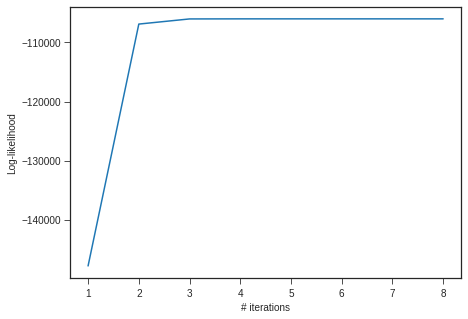

1 states: logL = -106013.342, AIC = 212050.685, BIC = 1.000
[(<pyhhmm.multinomial.MultinomialHMM object at 0x7f098188c490>, 212050.68467147354)]
Initialisation 1
iter: 0, log_likelihood = -128478.26946310283, delta = nan
iter: 1, log_likelihood = -110472.09640857184, delta = 18006.173054530984
iter: 2, log_likelihood = -110341.38626463914, delta = 130.7101439327089
iter: 3, log_likelihood = -110339.99346650312, delta = 1.3927981360175181
iter: 4, log_likelihood = -110339.97942908594, delta = 0.01403741717513185
iter: 5, log_likelihood = -110339.97928859961, delta = 0.00014048632874619216
iter: 6, log_likelihood = -110339.97928719479, delta = 1.4048273442313075e-06
iter: 7, log_likelihood = -110339.97928718066, delta = 1.4129909686744213e-08
Converged -> iter: 7, log_likelihood = -110339.97928718066


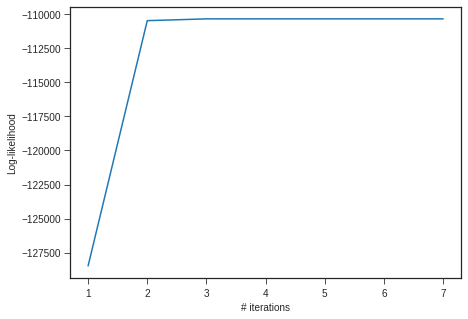

1 states: logL = -110339.979, AIC = 220703.959, BIC = 1.000
[(<pyhhmm.multinomial.MultinomialHMM object at 0x7f0981918b50>, 220703.9585743613)]
Initialisation 1
iter: 0, log_likelihood = -145474.2239747797, delta = nan
iter: 1, log_likelihood = -97213.45751027064, delta = 48260.76646450907
iter: 2, log_likelihood = -96917.6873152398, delta = 295.7701950308401
iter: 3, log_likelihood = -96914.04772504687, delta = 3.6395901929354295
iter: 4, log_likelihood = -96914.01031752683, delta = 0.03740752003795933
iter: 5, log_likelihood = -96914.0099423901, delta = 0.00037513673305511475
iter: 6, log_likelihood = -96914.00993863745, delta = 3.7526478990912437e-06
iter: 7, log_likelihood = -96914.00993859993, delta = 3.7514837458729744e-08
Converged -> iter: 7, log_likelihood = -96914.00993859993


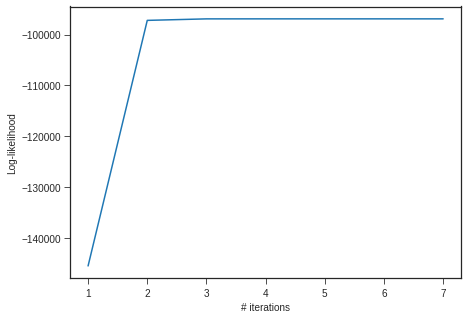

1 states: logL = -96914.010, AIC = 193852.020, BIC = 1.000
[(<pyhhmm.multinomial.MultinomialHMM object at 0x7f0981846790>, 193852.01987719987)]
Initialisation 1
iter: 0, log_likelihood = -190820.4076463122, delta = nan
iter: 1, log_likelihood = -134757.51794357417, delta = 56062.88970273803
iter: 2, log_likelihood = -134146.7944725703, delta = 610.7234710038756
iter: 3, log_likelihood = -134137.287017102, delta = 9.50745546829421
iter: 4, log_likelihood = -134137.18513365329, delta = 0.10188344871858135
iter: 5, log_likelihood = -134137.1841072826, delta = 0.0010263706790283322
iter: 6, log_likelihood = -134137.18409701114, delta = 1.0271469363942742e-05
iter: 7, log_likelihood = -134137.1840969088, delta = 1.023290678858757e-07
Converged -> iter: 7, log_likelihood = -134137.1840969088


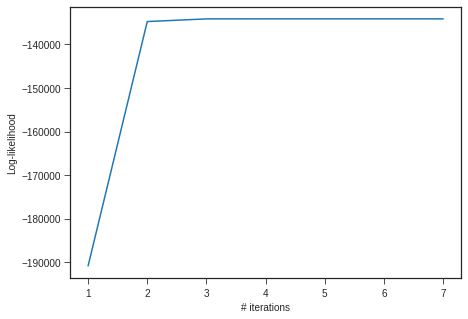

1 states: logL = -134137.184, AIC = 268298.368, BIC = 1.000
[(<pyhhmm.multinomial.MultinomialHMM object at 0x7f09813a5f10>, 268298.3681938176)]
Initialisation 1
iter: 0, log_likelihood = -125956.30955375597, delta = nan
iter: 1, log_likelihood = -108769.3295201929, delta = 17186.98003356307
iter: 2, log_likelihood = -108576.07393045466, delta = 193.25558973824081
iter: 3, log_likelihood = -108573.85143039795, delta = 2.222500056712306
iter: 4, log_likelihood = -108573.8288227847, delta = 0.022607613253057934
iter: 5, log_likelihood = -108573.8285963136, delta = 0.0002264710929011926
iter: 6, log_likelihood = -108573.82859404854, delta = 2.265063812956214e-06
iter: 7, log_likelihood = -108573.82859402618, delta = 2.2351741790771484e-08
Converged -> iter: 7, log_likelihood = -108573.82859402618


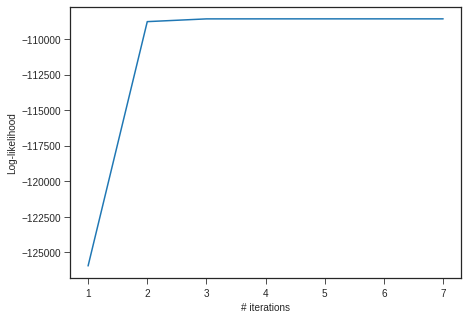

1 states: logL = -108573.829, AIC = 217171.657, BIC = 1.000
[(<pyhhmm.multinomial.MultinomialHMM object at 0x7f0981918f40>, 217171.65718805237)]
Initialisation 1
iter: 0, log_likelihood = -226374.21424648972, delta = nan
iter: 1, log_likelihood = -135813.78928426403, delta = 90560.42496222569
iter: 2, log_likelihood = -134489.5914494567, delta = 1324.1978348073317
iter: 3, log_likelihood = -134466.73259210403, delta = 22.858857352664927
iter: 4, log_likelihood = -134466.48024078028, delta = 0.2523513237538282
iter: 5, log_likelihood = -134466.47768964907, delta = 0.0025511312123853713
iter: 6, log_likelihood = -134466.4776641096, delta = 2.553945523686707e-05
iter: 7, log_likelihood = -134466.47766385428, delta = 2.553279045969248e-07
iter: 8, log_likelihood = -134466.4776638517, delta = 2.5902409106492996e-09
Converged -> iter: 8, log_likelihood = -134466.4776638517


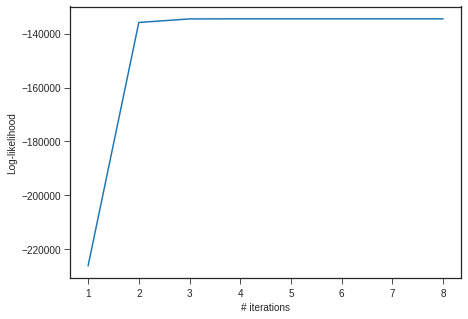

1 states: logL = -134466.478, AIC = 268956.955, BIC = 1.000
[(<pyhhmm.multinomial.MultinomialHMM object at 0x7f0998e0d2e0>, 268956.9553277034)]
Initialisation 1
iter: 0, log_likelihood = -124238.79531988713, delta = nan
iter: 1, log_likelihood = -106641.63197373551, delta = 17597.163346151618
iter: 2, log_likelihood = -106308.96446437444, delta = 332.66750936106837
iter: 3, log_likelihood = -106304.60854292716, delta = 4.355921447277069
iter: 4, log_likelihood = -106304.56335929541, delta = 0.04518363175156992
iter: 5, log_likelihood = -106304.562905735, delta = 0.00045356040936894715
iter: 6, log_likelihood = -106304.56290119792, delta = 4.537083441391587e-06
iter: 7, log_likelihood = -106304.56290115231, delta = 4.5605702325701714e-08
Converged -> iter: 7, log_likelihood = -106304.56290115231


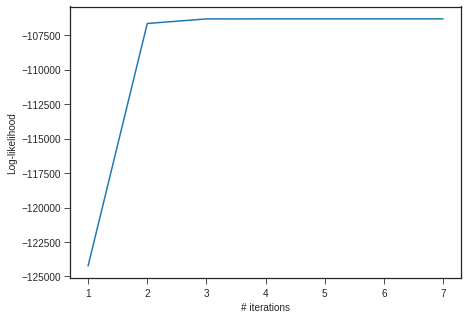

1 states: logL = -106304.563, AIC = 212633.126, BIC = 1.000
[(<pyhhmm.multinomial.MultinomialHMM object at 0x7f0981253a90>, 212633.12580230462)]
Initialisation 1
iter: 0, log_likelihood = -161206.02033156852, delta = nan
iter: 1, log_likelihood = -109973.88736900511, delta = 51232.13296256341
iter: 2, log_likelihood = -109290.25320722738, delta = 683.6341617777362
iter: 3, log_likelihood = -109279.41697308223, delta = 10.836234145142953
iter: 4, log_likelihood = -109279.30010091275, delta = 0.11687216948485002
iter: 5, log_likelihood = -109279.29892263733, delta = 0.0011782754154410213
iter: 6, log_likelihood = -109279.29891084509, delta = 1.1792246368713677e-05
iter: 7, log_likelihood = -109279.298910727, delta = 1.18088792078197e-07
Converged -> iter: 7, log_likelihood = -109279.298910727


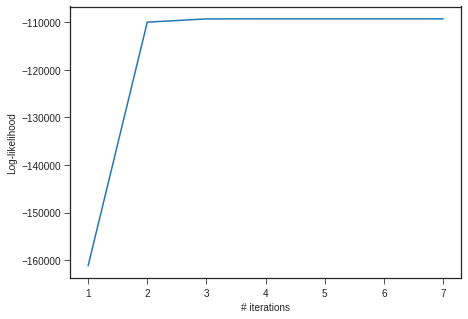

1 states: logL = -109279.299, AIC = 218582.598, BIC = 1.000
[(<pyhhmm.multinomial.MultinomialHMM object at 0x7f0981258d90>, 218582.597821454)]
Initialisation 1
iter: 0, log_likelihood = -111641.1976189983, delta = nan
iter: 1, log_likelihood = -90503.49808886407, delta = 21137.699530134225
iter: 2, log_likelihood = -90115.91075227619, delta = 387.5873365878797
iter: 3, log_likelihood = -90110.96740174503, delta = 4.9433505311608315
iter: 4, log_likelihood = -90110.91639064773, delta = 0.05101109729730524
iter: 5, log_likelihood = -90110.91587888068, delta = 0.0005117670516483486
iter: 6, log_likelihood = -90110.91587376116, delta = 5.1195238484069705e-06
iter: 7, log_likelihood = -90110.91587371015, delta = 5.1004462875425816e-08
Converged -> iter: 7, log_likelihood = -90110.91587371015


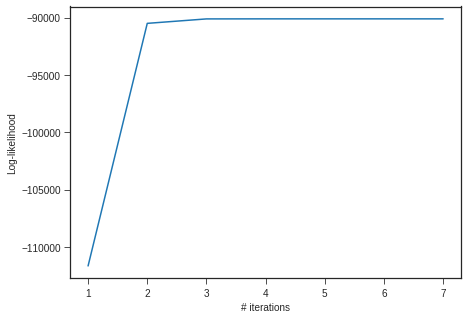

1 states: logL = -90110.916, AIC = 180245.832, BIC = 1.000
[(<pyhhmm.multinomial.MultinomialHMM object at 0x7f098122c640>, 180245.8317474203)]
Initialisation 1
iter: 0, log_likelihood = -133813.0438316102, delta = nan
iter: 1, log_likelihood = -102261.50659775276, delta = 31551.537233857453
iter: 2, log_likelihood = -101846.81272602291, delta = 414.69387172984716
iter: 3, log_likelihood = -101840.6445435729, delta = 6.168182450011955
iter: 4, log_likelihood = -101840.57881885256, delta = 0.06572472033440135
iter: 5, log_likelihood = -101840.57815713562, delta = 0.0006617169419769198
iter: 6, log_likelihood = -101840.57815051354, delta = 6.62208185531199e-06
iter: 7, log_likelihood = -101840.57815044737, delta = 6.616755854338408e-08
Converged -> iter: 7, log_likelihood = -101840.57815044737


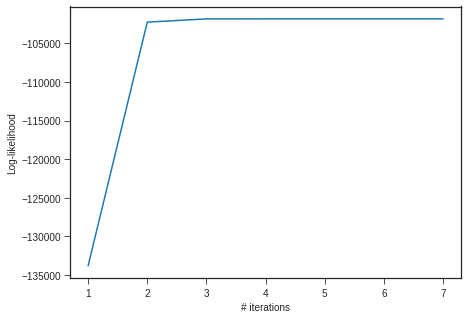

1 states: logL = -101840.578, AIC = 203705.156, BIC = 1.000
[(<pyhhmm.multinomial.MultinomialHMM object at 0x7f098128e790>, 203705.15630089474)]
Initialisation 1
iter: 0, log_likelihood = -157014.7420683473, delta = nan
iter: 1, log_likelihood = -105483.66299923921, delta = 51531.07906910808
iter: 2, log_likelihood = -104770.47183471467, delta = 713.1911645245418
iter: 3, log_likelihood = -104757.14999180124, delta = 13.321842913428554
iter: 4, log_likelihood = -104756.99940823088, delta = 0.1505835703574121
iter: 5, log_likelihood = -104756.9978816291, delta = 0.0015266017871908844
iter: 6, log_likelihood = -104756.99786634195, delta = 1.5287150745280087e-05
iter: 7, log_likelihood = -104756.99786618903, delta = 1.5291152521967888e-07
iter: 8, log_likelihood = -104756.99786618736, delta = 1.673470251262188e-09
Converged -> iter: 8, log_likelihood = -104756.99786618736


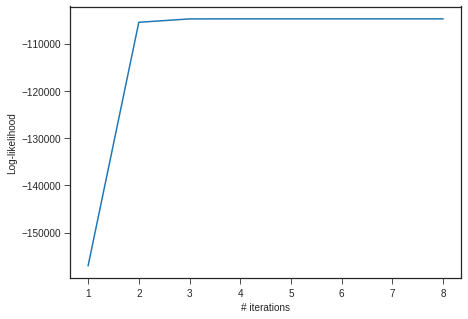

1 states: logL = -104756.998, AIC = 209537.996, BIC = 1.000
[(<pyhhmm.multinomial.MultinomialHMM object at 0x7f098122c5e0>, 209537.99573237472)]
Initialisation 1
iter: 0, log_likelihood = -125071.17238470694, delta = nan
iter: 1, log_likelihood = -105967.10187999895, delta = 19104.070504707983
iter: 2, log_likelihood = -105614.65478462722, delta = 352.4470953717391
iter: 3, log_likelihood = -105610.0756330543, delta = 4.579151572921546
iter: 4, log_likelihood = -105610.0282077079, delta = 0.047425346390809864
iter: 5, log_likelihood = -105610.02773172753, delta = 0.0004759803705383092
iter: 6, log_likelihood = -105610.02772696603, delta = 4.761503078043461e-06
iter: 7, log_likelihood = -105610.02772691827, delta = 4.775938577950001e-08
Converged -> iter: 7, log_likelihood = -105610.02772691827


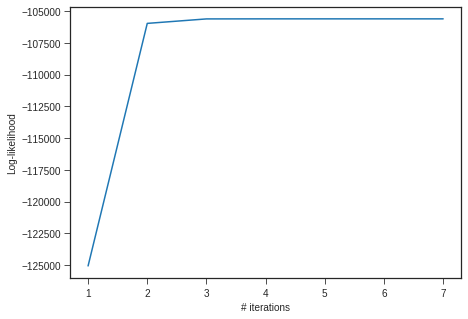

1 states: logL = -105610.028, AIC = 211244.055, BIC = 1.000
[(<pyhhmm.multinomial.MultinomialHMM object at 0x7f09811cb640>, 211244.05545383654)]
Initialisation 1
iter: 0, log_likelihood = -119754.0864793258, delta = nan
iter: 1, log_likelihood = -111744.23966393001, delta = 8009.84681539578
iter: 2, log_likelihood = -111576.65780606213, delta = 167.58185786788817
iter: 3, log_likelihood = -111574.51016360158, delta = 2.1476424605498323
iter: 4, log_likelihood = -111574.48799491422, delta = 0.02216868735558819
iter: 5, log_likelihood = -111574.48777250187, delta = 0.00022241234546527267
iter: 6, log_likelihood = -111574.48777027687, delta = 2.22500239033252e-06
iter: 7, log_likelihood = -111574.4877702547, delta = 2.2177118808031082e-08
Converged -> iter: 7, log_likelihood = -111574.4877702547


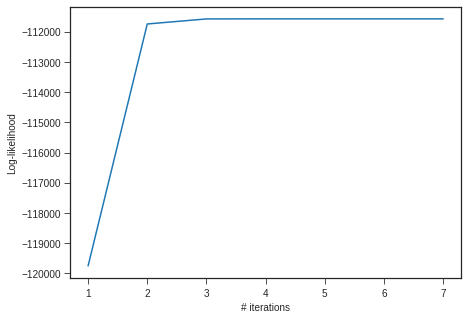

1 states: logL = -111574.488, AIC = 223172.976, BIC = 1.000
[(<pyhhmm.multinomial.MultinomialHMM object at 0x7f09812a17f0>, 223172.9755405094)]
Initialisation 1
iter: 0, log_likelihood = -157581.283456268, delta = nan
iter: 1, log_likelihood = -111741.42341609164, delta = 45839.860040176354
iter: 2, log_likelihood = -111242.2318902539, delta = 499.1915258377412
iter: 3, log_likelihood = -111235.68314511278, delta = 6.5487451411172515
iter: 4, log_likelihood = -111235.61501451513, delta = 0.06813059764681384
iter: 5, log_likelihood = -111235.614330368, delta = 0.0006841471331426874
iter: 6, log_likelihood = -111235.6143235239, delta = 6.844100425951183e-06
iter: 7, log_likelihood = -111235.61432345556, delta = 6.833579391241074e-08
Converged -> iter: 7, log_likelihood = -111235.61432345556


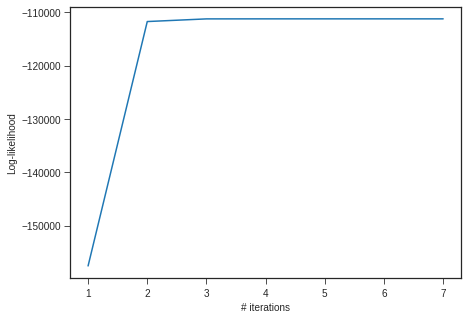

1 states: logL = -111235.614, AIC = 222495.229, BIC = 1.000
[(<pyhhmm.multinomial.MultinomialHMM object at 0x7f0980fff490>, 222495.22864691113)]
Initialisation 1
iter: 0, log_likelihood = -127262.31635364698, delta = nan
iter: 1, log_likelihood = -104289.3430070208, delta = 22972.973346626182
iter: 2, log_likelihood = -103775.16254662964, delta = 514.1804603911587
iter: 3, log_likelihood = -103767.77384930191, delta = 7.388697327725822
iter: 4, log_likelihood = -103767.6960765023, delta = 0.07777279961737804
iter: 5, log_likelihood = -103767.69529459276, delta = 0.0007819095335435122
iter: 6, log_likelihood = -103767.69528676897, delta = 7.823793566785753e-06
iter: 7, log_likelihood = -103767.6952866908, delta = 7.817288860678673e-08
Converged -> iter: 7, log_likelihood = -103767.6952866908


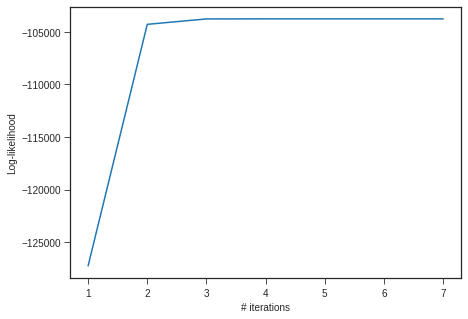

1 states: logL = -103767.695, AIC = 207559.391, BIC = 1.000
[(<pyhhmm.multinomial.MultinomialHMM object at 0x7f0981007e20>, 207559.3905733816)]
Initialisation 1
iter: 0, log_likelihood = -94766.96687812457, delta = nan
iter: 1, log_likelihood = -72060.72633433742, delta = 22706.24054378715
iter: 2, log_likelihood = -71753.63883491018, delta = 307.08749942724535
iter: 3, log_likelihood = -71749.74280835829, delta = 3.8960265518835513
iter: 4, log_likelihood = -71749.70254528038, delta = 0.04026307791355066
iter: 5, log_likelihood = -71749.70214126691, delta = 0.00040401346632279456
iter: 6, log_likelihood = -71749.70213722574, delta = 4.041168722324073e-06
iter: 7, log_likelihood = -71749.70213718512, delta = 4.062894731760025e-08
Converged -> iter: 7, log_likelihood = -71749.70213718512


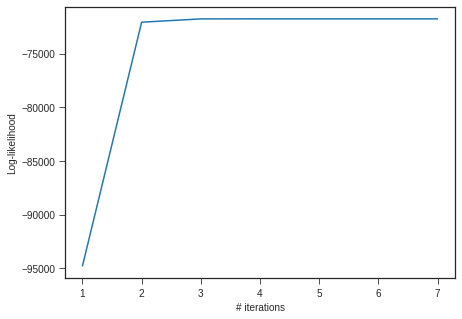

1 states: logL = -71749.702, AIC = 143523.404, BIC = 1.000
[(<pyhhmm.multinomial.MultinomialHMM object at 0x7f0980fbadc0>, 143523.40427437023)]
Initialisation 1
iter: 0, log_likelihood = -56471.59233465432, delta = nan
iter: 1, log_likelihood = -46467.58669477491, delta = 10004.005639879411
iter: 2, log_likelihood = -46289.22696029159, delta = 178.35973448331788
iter: 3, log_likelihood = -46286.76239075226, delta = 2.464569539333752
iter: 4, log_likelihood = -46286.736604210375, delta = 0.025786541882553138
iter: 5, log_likelihood = -46286.73634512359, delta = 0.0002590867879916914
iter: 6, log_likelihood = -46286.73634253155, delta = 2.592038072180003e-06
iter: 7, log_likelihood = -46286.73634250563, delta = 2.5916961021721363e-08
Converged -> iter: 7, log_likelihood = -46286.73634250563


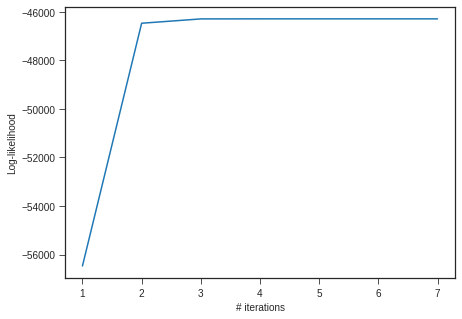

1 states: logL = -46286.736, AIC = 92597.473, BIC = 1.000
[(<pyhhmm.multinomial.MultinomialHMM object at 0x7f0980ff64c0>, 92597.47268501126)]
Initialisation 1
iter: 0, log_likelihood = -118771.56160186602, delta = nan
iter: 1, log_likelihood = -107101.36269819563, delta = 11670.198903670389
iter: 2, log_likelihood = -106786.42699298802, delta = 314.9357052076084
iter: 3, log_likelihood = -106781.32170165321, delta = 5.1052913348103175
iter: 4, log_likelihood = -106781.2666115102, delta = 0.05509014301060233
iter: 5, log_likelihood = -106781.26605611602, delta = 0.0005553941882681102
iter: 6, log_likelihood = -106781.26605055759, delta = 5.558424163609743e-06
iter: 7, log_likelihood = -106781.26605050193, delta = 5.566107574850321e-08
Converged -> iter: 7, log_likelihood = -106781.26605050193


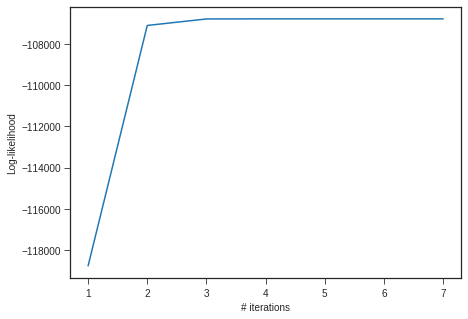

1 states: logL = -106781.266, AIC = 213586.532, BIC = 1.000
[(<pyhhmm.multinomial.MultinomialHMM object at 0x7f0981078460>, 213586.53210100386)]
Initialisation 1
iter: 0, log_likelihood = -132353.70237426212, delta = nan
iter: 1, log_likelihood = -111168.24082792367, delta = 21185.461546338454
iter: 2, log_likelihood = -110806.3719256349, delta = 361.8689022887702
iter: 3, log_likelihood = -110802.01806661469, delta = 4.353859020207892
iter: 4, log_likelihood = -110801.97352695258, delta = 0.04453966210712679
iter: 5, log_likelihood = -110801.97308051778, delta = 0.0004464348021429032
iter: 6, log_likelihood = -110801.97307605256, delta = 4.465226083993912e-06
iter: 7, log_likelihood = -110801.97307600768, delta = 4.487810656428337e-08
Converged -> iter: 7, log_likelihood = -110801.97307600768


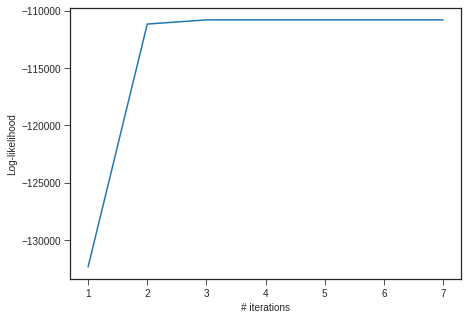

1 states: logL = -110801.973, AIC = 221627.946, BIC = 1.000
[(<pyhhmm.multinomial.MultinomialHMM object at 0x7f0980df8f70>, 221627.94615201536)]
Initialisation 1
iter: 0, log_likelihood = -117979.33346902388, delta = nan
iter: 1, log_likelihood = -104922.64647873475, delta = 13056.686990289134
iter: 2, log_likelihood = -104630.87722388864, delta = 291.76925484610547
iter: 3, log_likelihood = -104627.1995179232, delta = 3.677705965441419
iter: 4, log_likelihood = -104627.1616523087, delta = 0.0378656145039713
iter: 5, log_likelihood = -104627.1612725143, delta = 0.0003797943936660886
iter: 6, log_likelihood = -104627.16126871524, delta = 3.799068508669734e-06
iter: 7, log_likelihood = -104627.16126867749, delta = 3.7747668102383614e-08
Converged -> iter: 7, log_likelihood = -104627.16126867749


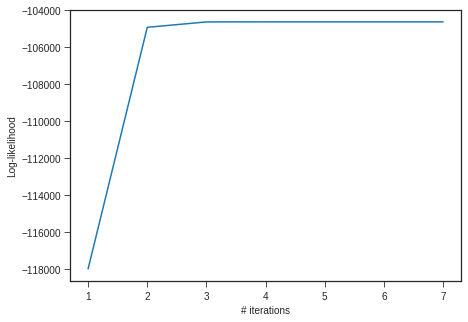

1 states: logL = -104627.161, AIC = 209278.323, BIC = 1.000
[(<pyhhmm.multinomial.MultinomialHMM object at 0x7f0980f89bb0>, 209278.32253735498)]
Initialisation 1
iter: 0, log_likelihood = -141200.51123434023, delta = nan
iter: 1, log_likelihood = -108327.58546728136, delta = 32872.92576705887
iter: 2, log_likelihood = -107835.3963694549, delta = 492.1890978264564
iter: 3, log_likelihood = -107827.6327655359, delta = 7.763603918996523
iter: 4, log_likelihood = -107827.5489481473, delta = 0.08381738860043697
iter: 5, log_likelihood = -107827.54810301433, delta = 0.0008451329777017236
iter: 6, log_likelihood = -107827.54809455594, delta = 8.458388037979603e-06
iter: 7, log_likelihood = -107827.54809447115, delta = 8.479401003569365e-08
Converged -> iter: 7, log_likelihood = -107827.54809447115


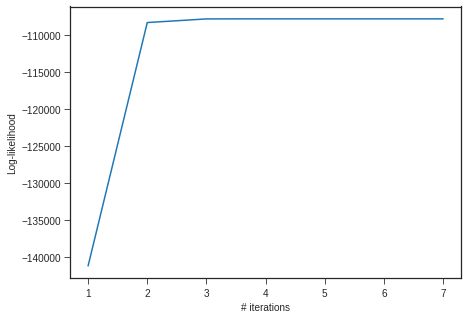

1 states: logL = -107827.548, AIC = 215679.096, BIC = 1.000
[(<pyhhmm.multinomial.MultinomialHMM object at 0x7f0980eaa6d0>, 215679.0961889423)]
Initialisation 1
iter: 0, log_likelihood = -117994.5525197675, delta = nan
iter: 1, log_likelihood = -108084.79075244875, delta = 9909.761767318749
iter: 2, log_likelihood = -107785.91692960598, delta = 298.8738228427683
iter: 3, log_likelihood = -107781.14752084635, delta = 4.769408759631915
iter: 4, log_likelihood = -107781.09635754417, delta = 0.05116330218152143
iter: 5, log_likelihood = -107781.09584209559, delta = 0.0005154485843377188
iter: 6, log_likelihood = -107781.09583693727, delta = 5.1583192544057965e-06
iter: 7, log_likelihood = -107781.09583688556, delta = 5.1702954806387424e-08
Converged -> iter: 7, log_likelihood = -107781.09583688556


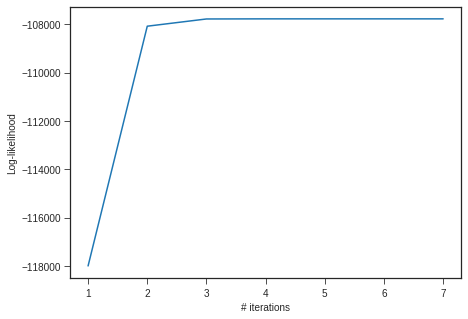

1 states: logL = -107781.096, AIC = 215586.192, BIC = 1.000
[(<pyhhmm.multinomial.MultinomialHMM object at 0x7f0980d134c0>, 215586.19167377113)]
Initialisation 1
iter: 0, log_likelihood = -130542.92516209144, delta = nan
iter: 1, log_likelihood = -110235.7487897517, delta = 20307.176372339745
iter: 2, log_likelihood = -109918.44330034796, delta = 317.3054894037341
iter: 3, log_likelihood = -109914.51321222595, delta = 3.9300881220115116
iter: 4, log_likelihood = -109914.4728418345, delta = 0.04037039144895971
iter: 5, log_likelihood = -109914.47243701585, delta = 0.00040481865289621055
iter: 6, log_likelihood = -109914.4724329662, delta = 4.049652488902211e-06
iter: 7, log_likelihood = -109914.47243292583, delta = 4.036701284348965e-08
Converged -> iter: 7, log_likelihood = -109914.47243292583


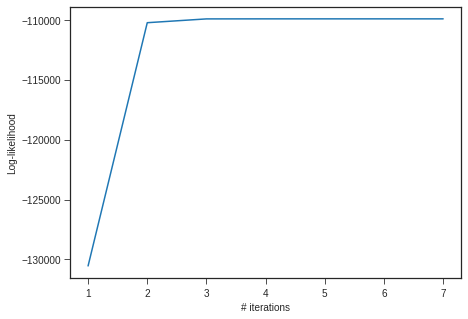

1 states: logL = -109914.472, AIC = 219852.945, BIC = 1.000
[(<pyhhmm.multinomial.MultinomialHMM object at 0x7f0980d135b0>, 219852.94486585166)]
Initialisation 1
iter: 0, log_likelihood = -121536.84089569809, delta = nan
iter: 1, log_likelihood = -97225.0543223167, delta = 24311.78657338138
iter: 2, log_likelihood = -96660.13656242607, delta = 564.917759890639
iter: 3, log_likelihood = -96651.45617717507, delta = 8.680385250991094
iter: 4, log_likelihood = -96651.36359815145, delta = 0.09257902362151071
iter: 5, log_likelihood = -96651.36266601586, delta = 0.0009321355901192874
iter: 6, log_likelihood = -96651.36265668781, delta = 9.328054147772491e-06
iter: 7, log_likelihood = -96651.36265659462, delta = 9.319046512246132e-08
Converged -> iter: 7, log_likelihood = -96651.36265659462


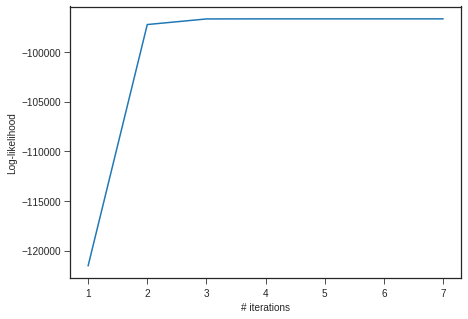

1 states: logL = -96651.363, AIC = 193326.725, BIC = 1.000
[(<pyhhmm.multinomial.MultinomialHMM object at 0x7f0980cbda00>, 193326.72531318924)]
Initialisation 1
iter: 0, log_likelihood = -133257.72577363235, delta = nan
iter: 1, log_likelihood = -112982.37232693283, delta = 20275.35344669952
iter: 2, log_likelihood = -112842.95079296322, delta = 139.4215339696093
iter: 3, log_likelihood = -112841.45554061038, delta = 1.4952523528481834
iter: 4, log_likelihood = -112841.44045445509, delta = 0.01508615528291557
iter: 5, log_likelihood = -112841.44030345594, delta = 0.0001509991561761126
iter: 6, log_likelihood = -112841.440301946, delta = 1.5099358279258013e-06
iter: 7, log_likelihood = -112841.44030193065, delta = 1.535227056592703e-08
Converged -> iter: 7, log_likelihood = -112841.44030193065


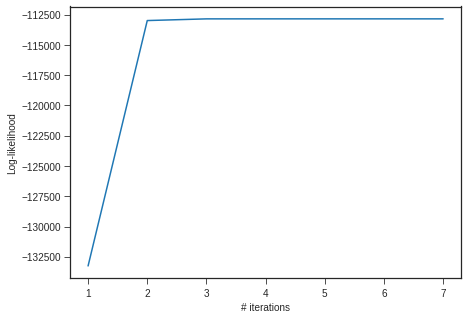

1 states: logL = -112841.440, AIC = 225706.881, BIC = 1.000
[(<pyhhmm.multinomial.MultinomialHMM object at 0x7f0980f52790>, 225706.8806038613)]
Initialisation 1
iter: 0, log_likelihood = -80503.86558276633, delta = nan
iter: 1, log_likelihood = -67563.7920209572, delta = 12940.073561809128
iter: 2, log_likelihood = -67421.95255518041, delta = 141.83946577679308
iter: 3, log_likelihood = -67420.29794155517, delta = 1.6546136252436554
iter: 4, log_likelihood = -67420.2810546143, delta = 0.016886940866243094
iter: 5, log_likelihood = -67420.28088538877, delta = 0.00016922553186304867
iter: 6, log_likelihood = -67420.28088369603, delta = 1.6927369870245457e-06
iter: 7, log_likelihood = -67420.28088367902, delta = 1.701118890196085e-08
Converged -> iter: 7, log_likelihood = -67420.28088367902


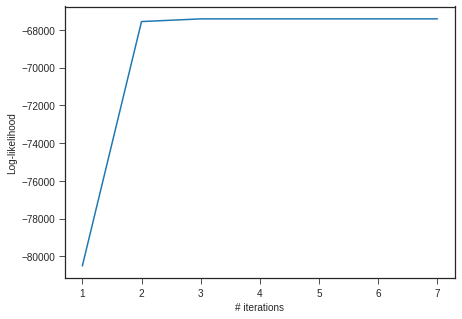

1 states: logL = -67420.281, AIC = 134864.562, BIC = 1.000
[(<pyhhmm.multinomial.MultinomialHMM object at 0x7f0980d13fa0>, 134864.56176735804)]
Initialisation 1
iter: 0, log_likelihood = -165967.85634706565, delta = nan
iter: 1, log_likelihood = -116465.38555987409, delta = 49502.47078719156
iter: 2, log_likelihood = -115895.47571001555, delta = 569.9098498585372
iter: 3, log_likelihood = -115887.02056920684, delta = 8.455140808713622
iter: 4, log_likelihood = -115886.9308490626, delta = 0.08972014424216468
iter: 5, log_likelihood = -115886.92994622048, delta = 0.0009028421191032976
iter: 6, log_likelihood = -115886.92993718671, delta = 9.033770766109228e-06
iter: 7, log_likelihood = -115886.92993709634, delta = 9.036739356815815e-08
Converged -> iter: 7, log_likelihood = -115886.92993709634


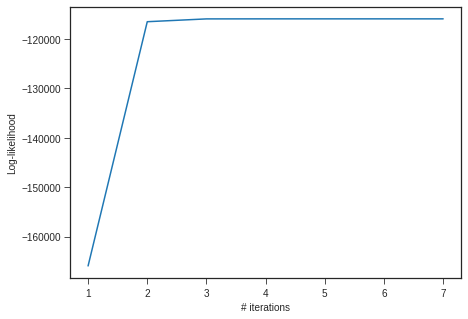

1 states: logL = -115886.930, AIC = 231797.860, BIC = 1.000
[(<pyhhmm.multinomial.MultinomialHMM object at 0x7f098109f940>, 231797.85987419268)]
Initialisation 1
iter: 0, log_likelihood = -137271.78854109862, delta = nan
iter: 1, log_likelihood = -112432.20153128187, delta = 24839.58700981675
iter: 2, log_likelihood = -112194.84196695859, delta = 237.35956432328385
iter: 3, log_likelihood = -112192.15626482316, delta = 2.6857021354226163
iter: 4, log_likelihood = -112192.12899311568, delta = 0.02727170748403296
iter: 5, log_likelihood = -112192.12871997037, delta = 0.00027314531325828284
iter: 6, log_likelihood = -112192.12871723897, delta = 2.731394488364458e-06
iter: 7, log_likelihood = -112192.12871721145, delta = 2.7517671696841717e-08
Converged -> iter: 7, log_likelihood = -112192.12871721145


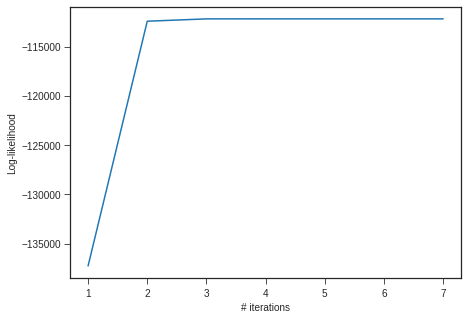

1 states: logL = -112192.129, AIC = 224408.257, BIC = 1.000
[(<pyhhmm.multinomial.MultinomialHMM object at 0x7f0980ff6d30>, 224408.2574344229)]
Initialisation 1
iter: 0, log_likelihood = -130345.22538638038, delta = nan
iter: 1, log_likelihood = -113125.64212055928, delta = 17219.5832658211
iter: 2, log_likelihood = -112708.92769010476, delta = 416.7144304545218
iter: 3, log_likelihood = -112702.98814358689, delta = 5.939546517867711
iter: 4, log_likelihood = -112702.92575351773, delta = 0.06239006915711798
iter: 5, log_likelihood = -112702.9251264053, delta = 0.0006271124293562025
iter: 6, log_likelihood = -112702.9251201309, delta = 6.274407496675849e-06
iter: 7, log_likelihood = -112702.92512006788, delta = 6.300979293882847e-08
Converged -> iter: 7, log_likelihood = -112702.92512006788


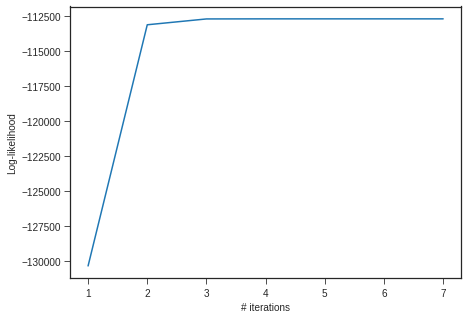

1 states: logL = -112702.925, AIC = 225429.850, BIC = 1.000
[(<pyhhmm.multinomial.MultinomialHMM object at 0x7f0981266fa0>, 225429.85024013577)]
Initialisation 1
iter: 0, log_likelihood = -11593.486793237704, delta = nan
iter: 1, log_likelihood = -9121.296329869103, delta = 2472.190463368601
iter: 2, log_likelihood = -9095.043049807244, delta = 26.253280061859186
iter: 3, log_likelihood = -9094.719786879221, delta = 0.32326292802281387
iter: 4, log_likelihood = -9094.716461282438, delta = 0.00332559678281541
iter: 5, log_likelihood = -9094.716427928377, delta = 3.335406108817551e-05
iter: 6, log_likelihood = -9094.716427594725, delta = 3.336517693242058e-07
iter: 7, log_likelihood = -9094.716427591396, delta = 3.3287506084889174e-09
Converged -> iter: 7, log_likelihood = -9094.716427591396


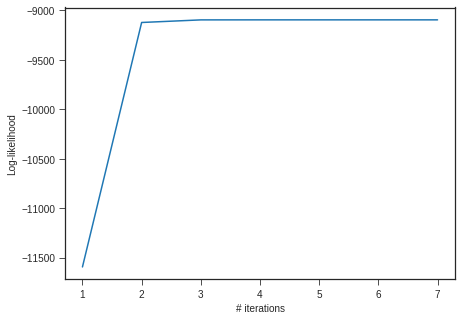

1 states: logL = -9094.716, AIC = 18213.433, BIC = 1.000
[(<pyhhmm.multinomial.MultinomialHMM object at 0x7f0980cbdaf0>, 18213.432855182793)]
Initialisation 1
iter: 0, log_likelihood = -129148.46361369755, delta = nan
iter: 1, log_likelihood = -104969.9023752629, delta = 24178.561238434646
iter: 2, log_likelihood = -104580.02611117727, delta = 389.8762640856294
iter: 3, log_likelihood = -104574.72748558497, delta = 5.298625592302415
iter: 4, log_likelihood = -104574.67202300452, delta = 0.05546258045069408
iter: 5, log_likelihood = -104574.67146569808, delta = 0.0005573064408963546
iter: 6, log_likelihood = -104574.67146012219, delta = 5.575886461883783e-06
iter: 7, log_likelihood = -104574.67146006646, delta = 5.573383532464504e-08
Converged -> iter: 7, log_likelihood = -104574.67146006646


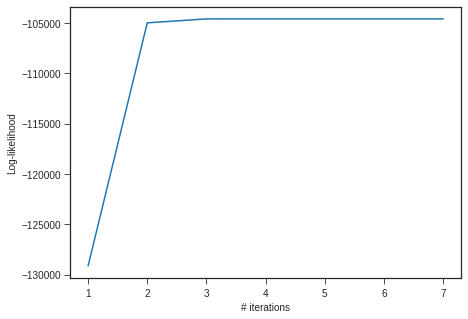

1 states: logL = -104574.671, AIC = 209173.343, BIC = 1.000
[(<pyhhmm.multinomial.MultinomialHMM object at 0x7f09811f6c70>, 209173.3429201329)]
Initialisation 1
iter: 0, log_likelihood = -120585.51772136499, delta = nan
iter: 1, log_likelihood = -104282.75338958787, delta = 16302.764331777114
iter: 2, log_likelihood = -103910.27163406176, delta = 372.48175552611065
iter: 3, log_likelihood = -103905.1639316402, delta = 5.107702421562863
iter: 4, log_likelihood = -103905.11052975919, delta = 0.0534018810139969
iter: 5, log_likelihood = -103905.1099932443, delta = 0.0005365148826967925
iter: 6, log_likelihood = -103905.10998787693, delta = 5.367372068576515e-06
iter: 7, log_likelihood = -103905.10998782328, delta = 5.365291144698858e-08
Converged -> iter: 7, log_likelihood = -103905.10998782328


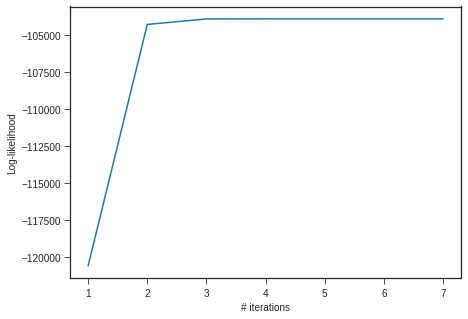

1 states: logL = -103905.110, AIC = 207834.220, BIC = 1.000
[(<pyhhmm.multinomial.MultinomialHMM object at 0x7f098132c7f0>, 207834.21997564656)]
Initialisation 1
iter: 0, log_likelihood = -133246.51053123001, delta = nan
iter: 1, log_likelihood = -109542.52869438955, delta = 23703.981836840467
iter: 2, log_likelihood = -109318.52155204062, delta = 224.00714234892803
iter: 3, log_likelihood = -109316.03612197284, delta = 2.4854300677834544
iter: 4, log_likelihood = -109316.01094709896, delta = 0.025174873881042004
iter: 5, log_likelihood = -109316.01069502017, delta = 0.0002520787820685655
iter: 6, log_likelihood = -109316.0106924988, delta = 2.5213666958734393e-06
iter: 7, log_likelihood = -109316.0106924733, delta = 2.550950739532709e-08
Converged -> iter: 7, log_likelihood = -109316.0106924733


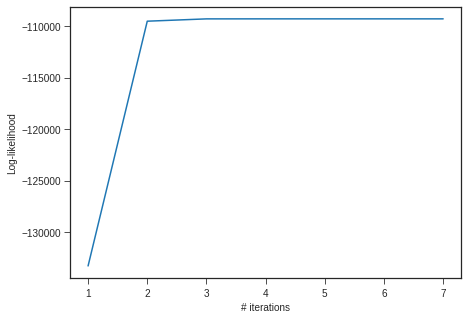

1 states: logL = -109316.011, AIC = 218656.021, BIC = 1.000
[(<pyhhmm.multinomial.MultinomialHMM object at 0x7f09819a1850>, 218656.0213849466)]
Initialisation 1
iter: 0, log_likelihood = -125228.88786245718, delta = nan
iter: 1, log_likelihood = -110367.60785757567, delta = 14861.280004881512
iter: 2, log_likelihood = -110179.09499835507, delta = 188.51285922060197
iter: 3, log_likelihood = -110176.70151924847, delta = 2.3934791065985337
iter: 4, log_likelihood = -110176.67680119407, delta = 0.02471805439563468
iter: 5, log_likelihood = -110176.67655318677, delta = 0.0002480073017068207
iter: 6, log_likelihood = -110176.67655070576, delta = 2.481014234945178e-06
iter: 7, log_likelihood = -110176.67655068095, delta = 2.4811015464365482e-08
Converged -> iter: 7, log_likelihood = -110176.67655068095


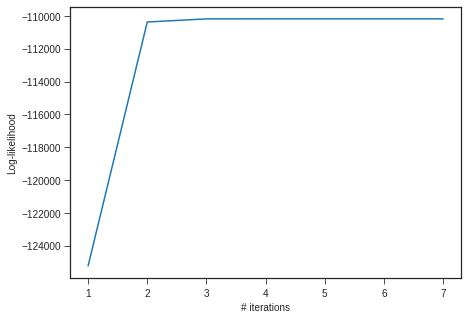

1 states: logL = -110176.677, AIC = 220377.353, BIC = 1.000
[(<pyhhmm.multinomial.MultinomialHMM object at 0x7f09811f66d0>, 220377.3531013619)]
Initialisation 1
iter: 0, log_likelihood = -138739.57863249903, delta = nan
iter: 1, log_likelihood = -104860.3293290401, delta = 33879.24930345893
iter: 2, log_likelihood = -104195.59162095241, delta = 664.7377080876904
iter: 3, log_likelihood = -104185.37653209918, delta = 10.215088853234192
iter: 4, log_likelihood = -104185.26739811875, delta = 0.10913398042612243
iter: 5, log_likelihood = -104185.26629906858, delta = 0.0010990501759806648
iter: 6, log_likelihood = -104185.2662880704, delta = 1.0998177458532155e-05
iter: 7, log_likelihood = -104185.26628796056, delta = 1.09837856143713e-07
Converged -> iter: 7, log_likelihood = -104185.26628796056


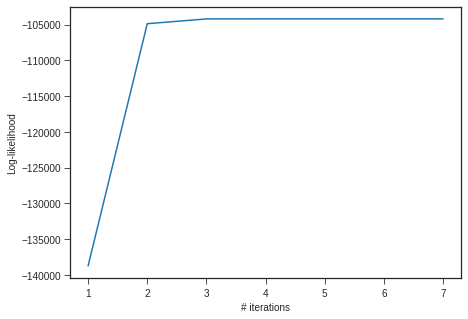

1 states: logL = -104185.266, AIC = 208394.533, BIC = 1.000
[(<pyhhmm.multinomial.MultinomialHMM object at 0x7f0980dbab20>, 208394.53257592113)]
Initialisation 1
iter: 0, log_likelihood = -121264.22342910815, delta = nan
iter: 1, log_likelihood = -108710.62329237332, delta = 12553.600136734836
iter: 2, log_likelihood = -108335.96913923662, delta = 374.65415313669655
iter: 3, log_likelihood = -108329.91457921753, delta = 6.054560019096243
iter: 4, log_likelihood = -108329.84931991318, delta = 0.06525930434872862
iter: 5, log_likelihood = -108329.84866208055, delta = 0.0006578326283488423
iter: 6, log_likelihood = -108329.84865549691, delta = 6.5836356952786446e-06
iter: 7, log_likelihood = -108329.8486554309, delta = 6.600748747587204e-08
Converged -> iter: 7, log_likelihood = -108329.8486554309


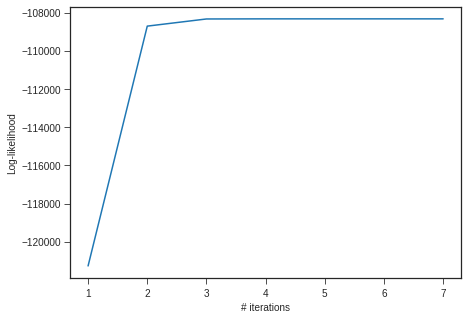

1 states: logL = -108329.849, AIC = 216683.697, BIC = 1.000
[(<pyhhmm.multinomial.MultinomialHMM object at 0x7f0981195d90>, 216683.6973108618)]
Initialisation 1
iter: 0, log_likelihood = -158400.00258185118, delta = nan
iter: 1, log_likelihood = -110610.12257046463, delta = 47789.88001138654
iter: 2, log_likelihood = -109834.3408630151, delta = 775.7817074495397
iter: 3, log_likelihood = -109822.22531050706, delta = 12.1155525080394
iter: 4, log_likelihood = -109822.0954016676, delta = 0.12990883945894893
iter: 5, log_likelihood = -109822.09409286053, delta = 0.0013088070700177923
iter: 6, log_likelihood = -109822.09407976257, delta = 1.3097960618324578e-05
iter: 7, log_likelihood = -109822.09407963173, delta = 1.3083626981824636e-07
iter: 8, log_likelihood = -109822.09407963033, delta = 1.3969838619232178e-09
Converged -> iter: 8, log_likelihood = -109822.09407963033


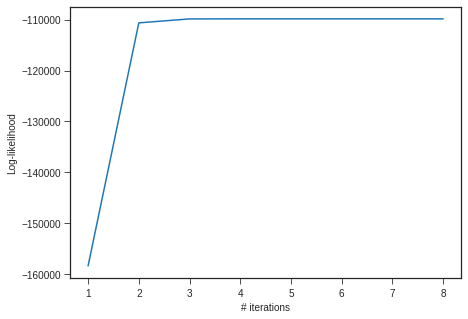

1 states: logL = -109822.094, AIC = 219668.188, BIC = 1.000
[(<pyhhmm.multinomial.MultinomialHMM object at 0x7f0981324790>, 219668.18815926067)]
Initialisation 1
iter: 0, log_likelihood = -127845.28349059311, delta = nan
iter: 1, log_likelihood = -111946.70834709254, delta = 15898.575143500566
iter: 2, log_likelihood = -111701.97365010515, delta = 244.73469698739063
iter: 3, log_likelihood = -111699.03744280853, delta = 2.936207296617795
iter: 4, log_likelihood = -111699.00741136349, delta = 0.030031445043277927
iter: 5, log_likelihood = -111699.00711035443, delta = 0.0003010090586030856
iter: 6, log_likelihood = -111699.0071073437, delta = 3.010733053088188e-06
iter: 7, log_likelihood = -111699.00710731327, delta = 3.042805474251509e-08
Converged -> iter: 7, log_likelihood = -111699.00710731327


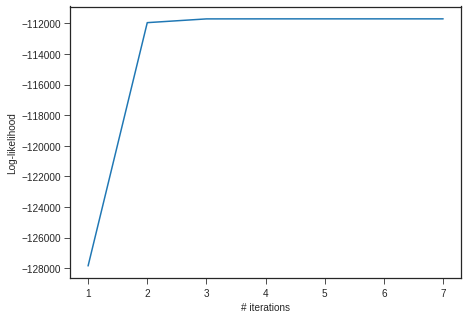

1 states: logL = -111699.007, AIC = 223422.014, BIC = 1.000
[(<pyhhmm.multinomial.MultinomialHMM object at 0x7f098129f8e0>, 223422.01421462654)]
Initialisation 1
iter: 0, log_likelihood = -133332.6657177146, delta = nan
iter: 1, log_likelihood = -112177.62251564726, delta = 21155.043202067347
iter: 2, log_likelihood = -111924.56930378807, delta = 253.05321185919456
iter: 3, log_likelihood = -111921.5795327692, delta = 2.9897710188670317
iter: 4, log_likelihood = -111921.54895876745, delta = 0.0305740017502103
iter: 5, log_likelihood = -111921.54865231844, delta = 0.0003064490156248212
iter: 6, log_likelihood = -111921.54864925315, delta = 3.0652881832793355e-06
iter: 7, log_likelihood = -111921.54864922231, delta = 3.083550836890936e-08
Converged -> iter: 7, log_likelihood = -111921.54864922231


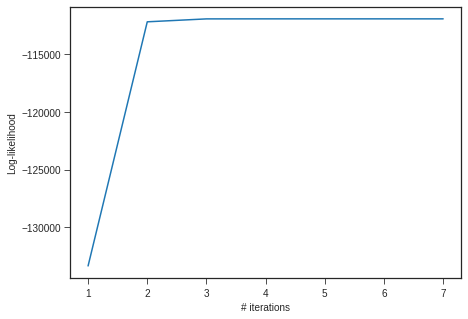

1 states: logL = -111921.549, AIC = 223867.097, BIC = 1.000
[(<pyhhmm.multinomial.MultinomialHMM object at 0x7f098120fdf0>, 223867.09729844463)]
Initialisation 1
iter: 0, log_likelihood = -152825.379824265, delta = nan
iter: 1, log_likelihood = -109115.75702848811, delta = 43709.622795776886
iter: 2, log_likelihood = -108229.34479346621, delta = 886.4122350218968
iter: 3, log_likelihood = -108216.07210447436, delta = 13.27268899185583
iter: 4, log_likelihood = -108215.93150075058, delta = 0.14060372377571184
iter: 5, log_likelihood = -108215.93008619326, delta = 0.0014145573222776875
iter: 6, log_likelihood = -108215.93007203903, delta = 1.4154225937090814e-05
iter: 7, log_likelihood = -108215.93007189767, delta = 1.413573045283556e-07
iter: 8, log_likelihood = -108215.93007189622, delta = 1.4551915228366852e-09
Converged -> iter: 8, log_likelihood = -108215.93007189622


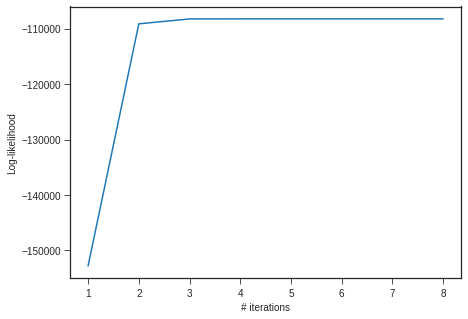

1 states: logL = -108215.930, AIC = 216455.860, BIC = 1.000
[(<pyhhmm.multinomial.MultinomialHMM object at 0x7f0980f6ecd0>, 216455.86014379244)]
Initialisation 1
iter: 0, log_likelihood = -142664.089370732, delta = nan
iter: 1, log_likelihood = -111374.08608842152, delta = 31290.00328231047
iter: 2, log_likelihood = -110942.88507738637, delta = 431.2010110351548
iter: 3, log_likelihood = -110937.15396199892, delta = 5.731115387447062
iter: 4, log_likelihood = -110937.094447498, delta = 0.05951450091379229
iter: 5, log_likelihood = -110937.09385002282, delta = 0.0005974751838948578
iter: 6, log_likelihood = -110937.09384404572, delta = 5.977097316645086e-06
iter: 7, log_likelihood = -110937.09384398628, delta = 5.944457370787859e-08
Converged -> iter: 7, log_likelihood = -110937.09384398628


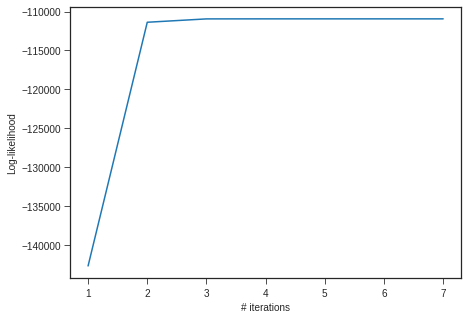

1 states: logL = -110937.094, AIC = 221898.188, BIC = 1.000
[(<pyhhmm.multinomial.MultinomialHMM object at 0x7f0980eb3c10>, 221898.18768797256)]
Initialisation 1
iter: 0, log_likelihood = -148991.60214851607, delta = nan
iter: 1, log_likelihood = -127504.31146541159, delta = 21487.290683104482
iter: 2, log_likelihood = -127123.25573183926, delta = 381.0557335723279
iter: 3, log_likelihood = -127118.49164164523, delta = 4.764090194032178
iter: 4, log_likelihood = -127118.44260467801, delta = 0.04903696721885353
iter: 5, log_likelihood = -127118.44211284463, delta = 0.0004918333870591596
iter: 6, log_likelihood = -127118.4421079249, delta = 4.919726052321494e-06
iter: 7, log_likelihood = -127118.44210787531, delta = 4.959292709827423e-08
Converged -> iter: 7, log_likelihood = -127118.44210787531


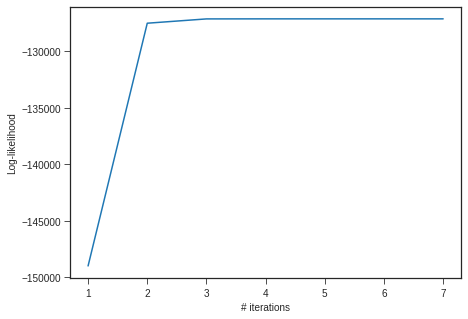

1 states: logL = -127118.442, AIC = 254260.884, BIC = 1.000
[(<pyhhmm.multinomial.MultinomialHMM object at 0x7f0980fa95e0>, 254260.88421575062)]
Initialisation 1
iter: 0, log_likelihood = -136267.15113035464, delta = nan
iter: 1, log_likelihood = -103621.99114825853, delta = 32645.159982096113
iter: 2, log_likelihood = -103076.73932986378, delta = 545.2518183947541
iter: 3, log_likelihood = -103068.58066209934, delta = 8.158667764437268
iter: 4, log_likelihood = -103068.49381310328, delta = 0.08684899605577812
iter: 5, log_likelihood = -103068.49293880703, delta = 0.0008742962527321652
iter: 6, log_likelihood = -103068.49293005852, delta = 8.748509571887553e-06
iter: 7, log_likelihood = -103068.4929299708, delta = 8.771894499659538e-08
Converged -> iter: 7, log_likelihood = -103068.4929299708


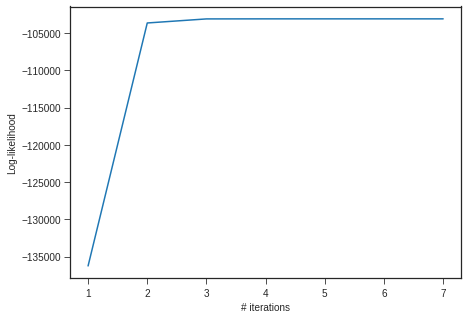

1 states: logL = -103068.493, AIC = 206160.986, BIC = 1.000
[(<pyhhmm.multinomial.MultinomialHMM object at 0x7f09810b5460>, 206160.9858599416)]
Initialisation 1
iter: 0, log_likelihood = -114176.51934753411, delta = nan
iter: 1, log_likelihood = -106311.0641880151, delta = 7865.455159519013
iter: 2, log_likelihood = -106136.20947845752, delta = 174.85470955757773
iter: 3, log_likelihood = -106133.97159283591, delta = 2.2378856216091663
iter: 4, log_likelihood = -106133.94848658258, delta = 0.023106253327568993
iter: 5, log_likelihood = -106133.94825475535, delta = 0.00023182723089121282
iter: 6, log_likelihood = -106133.94825243625, delta = 2.31909507419914e-06
iter: 7, log_likelihood = -106133.94825241316, delta = 2.3093889467418194e-08
Converged -> iter: 7, log_likelihood = -106133.94825241316


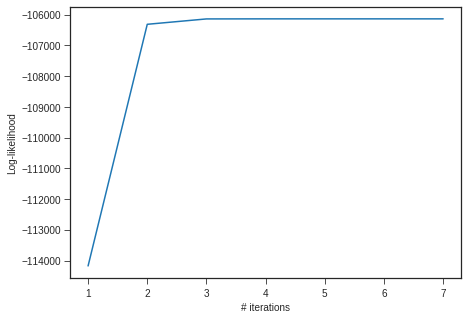

1 states: logL = -106133.948, AIC = 212291.897, BIC = 1.000
[(<pyhhmm.multinomial.MultinomialHMM object at 0x7f0981097490>, 212291.89650482632)]
Initialisation 1
iter: 0, log_likelihood = -146178.94847452609, delta = nan
iter: 1, log_likelihood = -106175.31709839881, delta = 40003.631376127276
iter: 2, log_likelihood = -105872.16288632834, delta = 303.15421207046893
iter: 3, log_likelihood = -105868.59812834614, delta = 3.56475798219617
iter: 4, log_likelihood = -105868.56166482715, delta = 0.036463518990785815
iter: 5, log_likelihood = -105868.56129933105, delta = 0.00036549610376823694
iter: 6, log_likelihood = -105868.56129567504, delta = 3.6560086300596595e-06
iter: 7, log_likelihood = -105868.56129563872, delta = 3.632158041000366e-08
Converged -> iter: 7, log_likelihood = -105868.56129563872


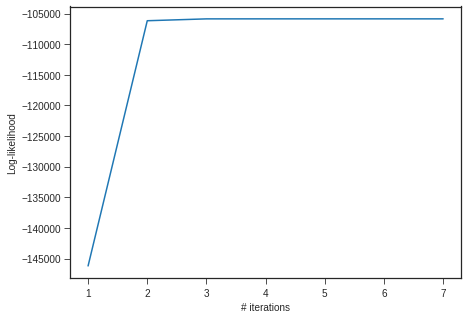

1 states: logL = -105868.561, AIC = 211761.123, BIC = 1.000
[(<pyhhmm.multinomial.MultinomialHMM object at 0x7f0981097520>, 211761.12259127744)]
Initialisation 1
iter: 0, log_likelihood = -125269.72924630139, delta = nan
iter: 1, log_likelihood = -107188.41779924554, delta = 18081.31144705585
iter: 2, log_likelihood = -106667.50434967196, delta = 520.913449573578
iter: 3, log_likelihood = -106658.04514615455, delta = 9.459203517413698
iter: 4, log_likelihood = -106657.94057324594, delta = 0.10457290860358626
iter: 5, log_likelihood = -106657.939516101, delta = 0.0010571449383860454
iter: 6, log_likelihood = -106657.93950551745, delta = 1.0583549737930298e-05
iter: 7, log_likelihood = -106657.93950541182, delta = 1.0563235264271498e-07
Converged -> iter: 7, log_likelihood = -106657.93950541182


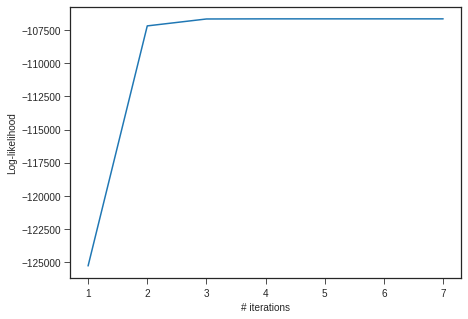

1 states: logL = -106657.940, AIC = 213339.879, BIC = 1.000
[(<pyhhmm.multinomial.MultinomialHMM object at 0x7f099209fcd0>, 213339.87901082364)]


In [15]:
lista_hmms = []

# El siguiente ciclo for puede tomar dias en correr debido al entrenamiento de los hmms
for i in range(3,len(list_sbjs)):
  # Entrenar los modelos para todos los sujetos y guardarlos en lista_hmms
  i_ = i+1
  lista_modelos, best_model = makeMarkovModelforChannel(list_sbjs[i][1],'sbj'+str(i+1))
  lista_hmms.append((lista_modelos,best_model))

# Download models created

In [16]:
!zip -r /content/models_1_states.zip /content/modelos
from google.colab import files
files.download("/content/models_1_states.zip")

  adding: content/modelos/ (stored 0%)
  adding: content/modelos/hmms_sbj46 (deflated 24%)
  adding: content/modelos/hmms_sbj8 (deflated 22%)
  adding: content/modelos/hmms_sbj6 (deflated 23%)
  adding: content/modelos/hmms_sbj41 (deflated 22%)
  adding: content/modelos/hmms_sbj43 (deflated 23%)
  adding: content/modelos/hmms_sbj24 (deflated 22%)
  adding: content/modelos/hmms_sbj49 (deflated 23%)
  adding: content/modelos/hmms_sbj4 (deflated 24%)
  adding: content/modelos/hmms_sbj28 (deflated 24%)
  adding: content/modelos/hmms_sbj21 (deflated 23%)
  adding: content/modelos/hmms_sbj25 (deflated 22%)
  adding: content/modelos/hmms_sbj36 (deflated 24%)
  adding: content/modelos/hmms_sbj12 (deflated 22%)
  adding: content/modelos/hmms_sbj30 (deflated 23%)
  adding: content/modelos/hmms_sbj26 (deflated 23%)
  adding: content/modelos/hmms_sbj17 (deflated 23%)
  adding: content/modelos/hmms_sbj37 (deflated 23%)
  adding: content/modelos/hmms_sbj27 (deflated 23%)
  adding: content/modelos/hm

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>